#**Mercadotecnia telefónica con aprendizaje supervisado**
Los programas de telemarketing se han venido usando por las empresas durante años como una forma de comunicarse con clientes potenciales de manera directa por vía telefónica. En los últimos años el uso de las técnicas de inteligencia artificial ha permitido potencializar el impacto de estos programas de mercadotecnia.

Un banco ha lanzado un nuevo plan de inversión a largo plazo a través de un programa de telemarketing y desea saber que tan exitoso se puede considerar este programa utilizando técnicas de aprendizaje supervisado. El programa es lanzado a clientes del banco, por lo que este estudio ayudará a optimizar los esfuerzos al conocer las características de los clientes más propensos a adquirir dicho plan de inversión.

 En la presente actividad tu objetivo es predecir si el entrevistado adquirirá el plan de inversión bancario de acuerdo con varias características que se conocen de dicho cliente.

In [18]:
# importar librerías

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

In [2]:
#Leer archivo y colocar los datos en un frame de Pandas
data = pd.read_csv("bank_marketing.csv")

In [3]:
# Mostrar información del DataFrame EmpleadosAttrition
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        9000 non-null   int64 
 1   job        9000 non-null   object
 2   marital    9000 non-null   object
 3   education  9000 non-null   object
 4   default    9000 non-null   object
 5   balance    9000 non-null   int64 
 6   housing    9000 non-null   object
 7   loan       9000 non-null   object
 8   contact    9000 non-null   object
 9   day        9000 non-null   int64 
 10  month      9000 non-null   object
 11  duration   9000 non-null   int64 
 12  campaign   9000 non-null   int64 
 13  pdays      9000 non-null   int64 
 14  previous   9000 non-null   int64 
 15  poutcome   9000 non-null   object
 16  y          9000 non-null   object
dtypes: int64(7), object(10)
memory usage: 1.2+ MB


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,31,self-employed,married,tertiary,no,2666,no,no,cellular,10,nov,318,2,97,6,success,yes
1,29,unemployed,single,unknown,no,1584,no,no,cellular,6,sep,245,1,-1,0,unknown,yes
2,41,blue-collar,married,secondary,no,2152,yes,no,cellular,17,nov,369,1,-1,0,unknown,no
3,50,blue-collar,married,secondary,no,84,yes,no,cellular,17,jul,18,8,-1,0,unknown,no
4,40,admin.,married,secondary,no,0,no,no,cellular,28,jul,496,2,182,11,success,yes


In [4]:
# Tamaño del dataset
data.shape

(9000, 17)

In [5]:
# Tipos de datos por columna
data.dtypes

,0
age,int64
job,object
marital,object
education,object
default,object
balance,int64
housing,object
loan,object
contact,object
day,int64


In [6]:
# Faltantes por columna
data.isna().sum()

,0
age,0
job,0
marital,0
education,0
default,0
balance,0
housing,0
loan,0
contact,0
day,0


In [7]:
#Transforma las variables categóricas de manera que puedan ser tratadas numéricamente

# Target: y -> 0/1
data['y_bin'] = data['y'].str.strip().str.lower().map({'yes':1, 'no':0})
y = data['y_bin'].astype(int)

# Variables de entrada
X = data.drop(columns=['y','y_bin'])

# Categóricas y numéricas
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()

# One-hot
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_cat = ohe.fit_transform(X[cat_cols])
X_cat_df = pd.DataFrame(X_cat, columns=ohe.get_feature_names_out(cat_cols), index=X.index)

# Concatenar numéricas + categóricas codificadas
X_encoded = pd.concat([X[num_cols], X_cat_df], axis=1)

print("Shape X_encoded:", X_encoded.shape)
X_encoded.head()

Shape X_encoded: (9000, 51)


,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,31,2666,10,318,2,97,6,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,29,1584,6,245,1,-1,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,41,2152,17,369,1,-1,0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,50,84,17,18,8,-1,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,40,0,28,496,2,182,11,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


•	Usé OneHotEncoder en las variables categóricas porque son nominales (no tienen orden). LabelEncoder impondría un orden artificial que no existe y podría afectar los modelos. One-hot evita ese problema y permite que los modelos asignen pesos independientes a cada categoría.

•	Para la variable objetivo y, se mapeó directamente a 0/1, equivalente a un label encoding binario, porque el modelo requiere números y la salida es naturalmente binaria.


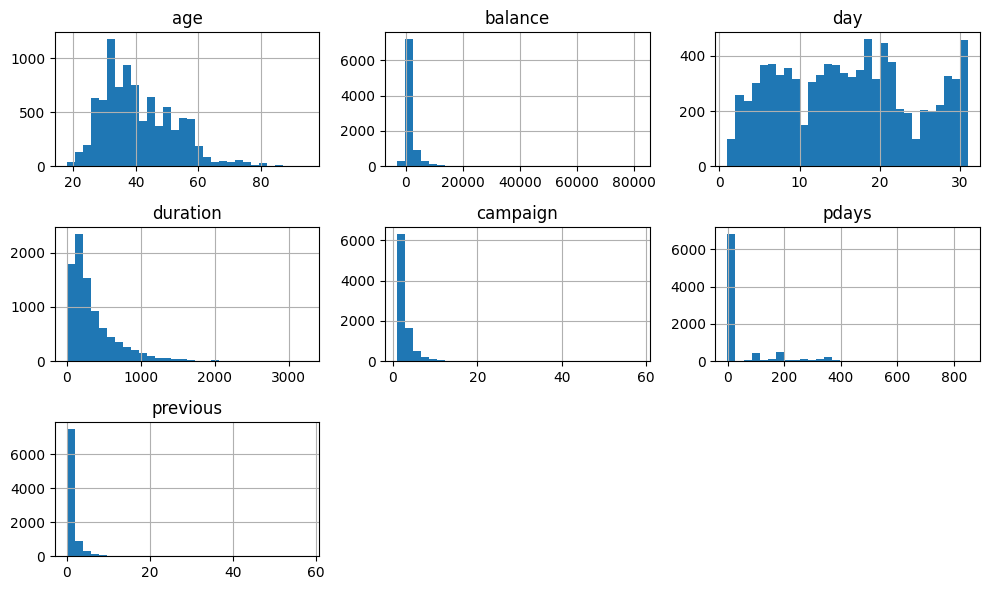

Paso 7 completo: transformaciones por sesgo y escalado aplicados.
Shape X_trans: (9000, 52)


/tmp/ipython-input-3719649198.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.58496748 5.20948615 4.57471098 ... 5.21493576 5.65248918 4.78749174]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_trans.loc[mask, 'pdays'] = np.log1p(X_trans.loc[mask, 'pdays'])


In [8]:
#Transforma las variables numéricas en los casos que se tenga algún tipo de sesgo.

# Columnas numéricas originales
num_cols = ['age','balance','day','duration','campaign','pdays','previous']

# Visualización rápida del sesgo
X_encoded[num_cols].hist(figsize=(10,6), bins=30)
plt.tight_layout()
plt.show()

# Transformaciones por sesgo
X_trans = X_encoded.copy()

# Log1p para colas largas (asegura no negativos)
for col in ['balance','duration','campaign','previous']:
    X_trans[col] = np.log1p(np.maximum(X_trans[col], 0))

# pdays: -1 significa "no contactado antes"
X_trans['pdays_was_minus1'] = (X_trans['pdays'] == -1).astype(int)
mask = X_trans['pdays'] > -1
X_trans.loc[mask, 'pdays'] = np.log1p(X_trans.loc[mask, 'pdays'])
# Nota: mantenemos -1 sin transformar y capturado en la variable binaria

# Escalado estándar (útil para los modelos de pasos 10 y 11)
scaler = StandardScaler()
cols_a_escalar = ['age','balance','day','duration','campaign','pdays','previous']
X_trans[cols_a_escalar] = scaler.fit_transform(X_trans[cols_a_escalar])

print("Paso 7 completo: transformaciones por sesgo y escalado aplicados.")
print("Shape X_trans:", X_trans.shape)

- Se observó sesgo (distribuciones con colas largas) en balance, duration, campaign y previous; se aplicó log1p para reducir asimetría.

- Se estandarizaron las variables numéricas para mejorar la estabilidad de la regresión logística y la red neuronal.

In [9]:
# Considera la variable “y” como la variable de salida y el resto de las variables como las variables de entrada.

# y: salida binaria 0/1
y = data['y'].str.strip().str.lower().map({'yes': 1, 'no': 0}).astype(int)

# X: todas las características ya codificadas y transformadas (del Paso 7)
X = X_trans.copy()

print("X:", X.shape)
print("y:", y.shape)

X: (9000, 52)
y: (9000,)


In [10]:
#Particiona los datos en los conjuntos de entrenamiento, validación y prueba en 60%, 20% y 20%, respectivamente.

# 20% prueba
x_train_validation, x_test, y_train_validation, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# Del 80% restante, 25% validación (equivale a 20% del total)
x_train, x_validation, y_train, y_validation = train_test_split(
    x_train_validation, y_train_validation, test_size=0.25, random_state=42
)

# Verificar dimensiones
print("Dimensión X_train_set:\t\t", x_train.shape)
print("Dimensión X_validation_set:\t", x_validation.shape)
print("Dimensión X_test_set:\t\t", x_test.shape)

print("Dimensión Y_train_set:\t\t", y_train.shape)
print("Dimensión Y_validation_set:\t", y_validation.shape)
print("Dimensión Y_test_set:\t\t", y_test.shape)

Dimensión X_train_set:		 (5400, 52)
Dimensión X_validation_set:	 (1800, 52)
Dimensión X_test_set:		 (1800, 52)
Dimensión Y_train_set:		 (5400,)
Dimensión Y_validation_set:	 (1800,)
Dimensión Y_test_set:		 (1800,)


###**Regresión Logística**

In [11]:
# Aplica el modelo Regresión Logística en el conjunto de entrenamiento

# Modelo base
modelo_RL_base = LogisticRegression(penalty='l2', solver='lbfgs', random_state=5, max_iter=1000)

# Entrenar
modelo_RL_base.fit(x_train, np.ravel(y_train))

# Accuracy
acc_val = modelo_RL_base.score(x_validation, y_validation)
acc_test = modelo_RL_base.score(x_test, y_test)
print("Accuracy validación:", acc_val, 4)
print("Accuracy prueba:", acc_test, 4)


Accuracy validación: 0.8177777777777778 4
Accuracy prueba: 0.8277777777777777 4


In [12]:
# Matriz de confusión en validación
y_val_pred = modelo_RL_base.predict(x_validation)
cm_val = confusion_matrix(y_validation, y_val_pred)
print("\nMatriz de confusión (validación):\n", cm_val)


Matriz de confusión (validación):
 [[869 166]
 [162 603]]


Para esta Regresión Logística obtuvimos: accuracy de 0.8178 que es igual a 81.78% y la matriz de confusión muestra 869 verdaderos negativos, 603 verdaderos positivos, con 166 falsos positivos y 162 falsos negativos.

In [13]:
#Con max_iter muy bajo

modelo_RL_hyper = LogisticRegression(C=0.1, penalty='l2', solver='lbfgs', random_state=5, max_iter=5)
modelo_RL_hyper.fit(x_train, np.ravel(y_train))
print('Accuracy prueba (score, max_iter=5):', round(modelo_RL_hyper.score(x_test, y_test), 4))

Accuracy prueba (score, max_iter=5): 0.8111


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [14]:
#Buscar mejores parámetros

parameters = {'C': [0.1, 0.15, 0.18, 0.2, 0.22, 0.24, 0.28, 0.3],
              'penalty': ('l2', 'elasticnet', 'none'),
              'solver': ('newton-cg', 'saga', 'lbfgs', 'sag')}

RL_grid = LogisticRegression(max_iter=10000)
modelo_RL_grid = GridSearchCV(RL_grid, parameters)

modelo_RL_grid.fit(x_train, np.ravel(y_train))

print(modelo_RL_grid)

print("Los mejores valores encontrados son %s con un score de %0.2f"
      % (modelo_RL_grid.best_params_, modelo_RL_grid.best_score_))

print(modelo_RL_grid.score(x_test, y_test))

GridSearchCV(estimator=LogisticRegression(max_iter=10000),
             param_grid={'C': [0.1, 0.15, 0.18, 0.2, 0.22, 0.24, 0.28, 0.3],
                         'penalty': ('l2', 'elasticnet', 'none'),
                         'solver': ('newton-cg', 'saga', 'lbfgs', 'sag')})
Los mejores valores encontrados son {'C': 0.2, 'penalty': 'l2', 'solver': 'newton-cg'} con un score de 0.83
0.8288888888888889


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
320 fits failed out of a total of 480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solv

In [15]:
#Intenta entonces ahora el entrenamiento solo con estos mejores valores encontrados:

modelo_RL_tmp = LogisticRegression(C=.2, penalty='l2', solver='newton-cg', max_iter=100)

modelo_RL_tmp.fit(x_train, np.ravel(y_train))
print( modelo_RL_tmp.score(x_test, y_test))

0.8288888888888889


In [16]:
# Matriz de confusión en validación
y_val_pred_tmp= modelo_RL_tmp.predict(x_validation)
cm_val_tmp = confusion_matrix(y_validation, y_val_pred_tmp)
print("\nMatriz de confusión (validación):\n", cm_val_tmp)


Matriz de confusión (validación):
 [[868 167]
 [162 603]]


La Regresión Logística, tras ajustar hiperparámetros, alcanzó un desempeño sólido y estable. Con la configuración C=0.2, penalty=l2 y solver=newton-cg (max_iter=100), el modelo obtuvo un accuracy de 0.8289 en el conjunto de prueba y una matriz de confusión en validación de [[868, 167], [162, 603]], mostrando buen equilibrio entre verdaderos positivos y negativos.

##**Red Neuronal**

In [19]:
#Aplica el modelo Red Neuronal en el conjunto de entrenamiento

# Modelo base: una capa oculta con 32 neuronas y número de iteraciones definido
modelo_MLP_base = MLPClassifier(hidden_layer_sizes=(32,), max_iter=1000, random_state=42)

# Entrenar
modelo_MLP_base.fit(x_train, np.ravel(y_train))

# Validación con score
acc_val_mlp = modelo_MLP_base.score(x_validation, y_validation)
print("Accuracy validación:", acc_val_mlp)

# Matriz de confusión
y_val_pred_mlp = modelo_MLP_base.predict(x_validation)
cm_val_mlp = confusion_matrix(y_validation, y_val_pred_mlp)
print("\nMatriz de confusión:\n", cm_val_mlp)

Accuracy validación: 0.83

Matriz de confusión:
 [[864 171]
 [135 630]]


In [21]:
# Probamos varias configuraciones de neuronas y algunas iteraciones
configs = [
    {'hidden_layer_sizes': (16,), 'max_iter': 800},
    {'hidden_layer_sizes': (32,), 'max_iter': 1000},
    {'hidden_layer_sizes': (64,), 'max_iter': 1200},
    {'hidden_layer_sizes': (32, 16), 'max_iter': 1200},  # dos capas ocultas
    {'hidden_layer_sizes': (64, 32), 'max_iter': 1500},  # dos capas ocultas
]

mejor_acc = -1
mejor_cfg = None
mejor_mlp = None

for cfg in configs:
    mlp = MLPClassifier(hidden_layer_sizes=cfg['hidden_layer_sizes'], max_iter=cfg['max_iter'], random_state=42)
    mlp.fit(x_train, np.ravel(y_train))
    acc = mlp.score(x_validation, y_validation)
    print(f"Config {cfg} -> accuracy validación (score): {acc:.4f}")
    if acc > mejor_acc:
        mejor_acc = acc
        mejor_cfg = cfg
        mejor_mlp = mlp

print("\nMejor configuración MLP (estilo base):", mejor_cfg, "accuracy validación:", round(mejor_acc, 4))

# Matriz de confusión del mejor en validación
y_val_pred_best_mlp = mejor_mlp.predict(x_validation)
cm_val_best_mlp = confusion_matrix(y_validation, y_val_pred_best_mlp)
print("\nMatriz de confusión:\n", cm_val_best_mlp)

Config {'hidden_layer_sizes': (16,), 'max_iter': 800} -> accuracy validación (score): 0.8378
Config {'hidden_layer_sizes': (32,), 'max_iter': 1000} -> accuracy validación (score): 0.8300
Config {'hidden_layer_sizes': (64,), 'max_iter': 1200} -> accuracy validación (score): 0.7994
Config {'hidden_layer_sizes': (32, 16), 'max_iter': 1200} -> accuracy validación (score): 0.7933
Config {'hidden_layer_sizes': (64, 32), 'max_iter': 1500} -> accuracy validación (score): 0.8139

Mejor configuración MLP (estilo base): {'hidden_layer_sizes': (16,), 'max_iter': 800} accuracy validación: 0.8378

Matriz de confusión:
 [[866 169]
 [123 642]]


- Mejor configuración MLP: hidden_layer_sizes=(16,), max_iter=800
- Accuracy validación: 0.8378
- Matriz de confusión en validación: [[866, 169], [123, 642]]
- Interpretación: el MLP reduce falsos negativos (123) y aumenta verdaderos positivos (642) respecto a configuraciones anteriores, manteniendo falsos positivos razonables (169). Esto sugiere que la red neuronal está capturando relaciones no lineales útiles para el problema.

In [23]:
#Selecciona el mejor modelo encontrado
log_best = LogisticRegression(C=0.2, penalty='l2', solver='newton-cg', max_iter=100, random_state=42)
log_best.fit(x_train, np.ravel(y_train))
acc_val_log = log_best.score(x_validation, y_validation)

mlp_best = MLPClassifier(hidden_layer_sizes=(16,), max_iter=800, random_state=42)
mlp_best.fit(x_train, np.ravel(y_train))
acc_val_mlp = mlp_best.score(x_validation, y_validation)

print("Accuracy validación LogReg:", round(acc_val_log, 4))
print("Accuracy validación MLP:", round(acc_val_mlp, 4))

Accuracy validación LogReg: 0.8172
Accuracy validación MLP: 0.8378


In [24]:
#Se encontro que el mejor modelo es MLP, por lo tanto:

best_mlp = MLPClassifier(hidden_layer_sizes=(16,), max_iter=800, random_state=42)
best_mlp.fit(x_train, np.ravel(y_train))

# Desempeño final
acc_test_final = best_mlp.score(x_test, y_test)
y_test_pred_final = best_mlp.predict(x_test)
cm_test_final = confusion_matrix(y_test, y_test_pred_final)

print("Modelo final seleccionado: MLP (16,), max_iter=800")
print("Accuracy final:", round(acc_test_final, 4))
print("Matriz de confusión:\n", cm_test_final)

Modelo final seleccionado: MLP (16,), max_iter=800
Accuracy final: 0.8539
Matriz de confusión:
 [[882 133]
 [130 655]]


###**Conclusión:**

En este reto, la predicción de la suscripción al depósito a plazo se resolvió eficazmente con aprendizaje supervisado. Tras transformar las variables categóricas con OneHotEncoder y aplicar transformaciones y escalado a las numéricas con sesgo, la Regresión Logística ofreció un desempeño sólido y la Red Neuronal (MLP) capturó mejor relaciones no lineales, resultando el modelo final con accuracy en prueba de 0.8539 y una matriz de confusión que evidencia buen equilibrio entre verdaderos positivos y falsos negativos. Esto muestra que la preparación de datos y la selección de hiperparámetros impactan directamente en el rendimiento.


**¿Qué puedes decir acerca del uso de técnicas de inteligencia artificial en problemas de mercadotecnia?**

La IA ha aportado valor a la mercadotecnia al elevar la precisión de targeting, optimizar recursos y aumentar la efectividad de campañas. Para ello es importante que esta se acompañe de una buena ingeniería de datos, métricas claras y validaciones robustas.

Puede:
- Identificar clientes con mayor propensión, optimizando tiempo y costos.
- Adaptar y proponer ofertas y mensajes personalizados según carcaterísticas deseadas.
- Como el caso de este ejercicio, puede comparar modelos, ajustar hiperparámetros y actualizar con nuevos datos pra amejora de desempeño, medición y mejora continua.
- Procesar grandes volúmenes de clientes y campañas con decisiones consistentes y reproducibles.

En conclusión, sabiendo hacer el correcto uso de ella y teninendo una buena preparación de datos, puede ayudar muchos a reducir tiempo y costos y optimizar trabajo.